# PLOT OF WEIGHTED VARIABLES ANOMALIES

In [1]:
import xarray as xr
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.util import add_cyclic_point
import intake, intake_esm
import os
import sys
from pathlib import Path
from glob import glob
import itertools
import time
import seaborn as sns
import math
import scipy.stats as st
import requests

import warnings
warnings.filterwarnings('ignore')

%run functions.ipynb

In [14]:
'''
Les fichiers sont stockés dans deux catalogues :
    - PMIPCat.json : Modèles Paleo
    - CMIPCat.json : Modèles Actuel (avec piControl notamment)
'''

PMIP = intake.open_esm_datastore("PMIPCat.json")

In [15]:
CMIP = intake.open_esm_datastore('CMIPCat.json')

### Preparation des données masques

In [16]:
'''
Import de données terrestre pouvant être utilisée comme
un masque via la fonction 'mask'.

Les étapes :
    - Définition de la résolution pour le futur regrillage
    - import des données via le catalogue PMIPCat
    - Regridde pour être comparé avec d'autres futures données
'''

res_lat = 1.25
res_lon = 1.75

land = PMIP.search(
    institution_id = 'AWI',
    source_id = 'AWI-ESM-1-1-LR',
    table_id = 'Lmon',
    experiment_id = 'lig127k',
    member_id = "r1i1p1f1", 
    latest = True,
    variable_id = 'gpp'
    )

land_ds = xr.open_mfdataset(
    list(land.df["path"]), 
    chunks = 200, 
    use_cftime=True, 
    decode_cf=True
    )
land_ds = land_ds.mean('time')
with ProgressBar():
    land_ds = land_ds.compute()

land_ds = regrid(
    land_ds, 
    res_lat, 
    res_lon, 
    -90, 90, 0, 360
    )

land_ds = land_ds.where((land_ds.coords['lon'] < 120) & (land_ds.coords['lon'] > 20) & (land_ds.coords['lat'] < -10) & (land_ds.coords['lat'] > -80), drop = True)

[########################################] | 100% Completed |  1.8s


### Certaines données ont été enregistrées et peuvent être ouvertes

### Sinon : création des données d'anomalies pondérées par l'évaporation

# PMIP3 Data

In [14]:
dir_pmip3, pmip3 = PMIP3_dic()
var_def = var_dic()

var = 'hurs'
var_list = ['evspsbl', var]
realm = 'Amon'
inst = PMIP.df['institution_id'].unique()
source = PMIP.df['source_id'].unique()
date = ['lgm', 'lig127k']
grid = ['gn', 'gr1', 'gr']
res_lat = 1.25
res_lon = 1.75
levels = np.arange(230, 3, 0.5)

# Premieres zones utiliées
'''
zones = {
    'S':[-55, -80, 20, 120], 
    'SW': [-25, -55, 20, 70], 
    'SE':[-25, -55, 70, 120], 
    'W':[20, -25, 20, 60], 
    'E':[-10, -25, 60, 120], 
    'NE':[20, -10, 60, 100], 
    'Global':[20, -80, 20, 100]
    }
'''

# Second test
zones = {
    'S':[-55, -80, 20, 120], 
    'SW': [-25, -55, 20, 70], 
    'SE':[-25, -55, 70, 120], 
    'N':[-10, -25, 20, 120], 
    'Global' : [-10, -80, 20, 120]
    }
glob = [-10, -80, 20, 120]

df_pmip3 = pd.DataFrame(
    columns = [
        '{}'.format(var), 'zone', 'institute', 'source', 'period', 'grid'
        ])


for model in pmip3 :
    lst_path = []
    for v in var_list :
        file_dir, filename = read_model(
            model, 
            'lgm',
            var_def, 
            v, 
            dir_pmip3)
        lst_path.append(file_dir)
    if os.path.exists(lst_path[0]) & os.path.exists(lst_path[1]) :
        
        # LGM + Variable souhaité
        file_dir, filename = read_model(
            model, 
            'lgm',
            var_def, 
            var, 
            dir_pmip3
            )  
        dsTAS = xr.open_mfdataset(filename,
                                  chunks = 500, 
                                  use_cftime=True, 
                                  decode_cf=True)
        dsTAS = dsTAS.mean(['time']).where((dsTAS.coords['lon'] < 120) & (dsTAS.coords['lon'] > 20) & (dsTAS.coords['lat'] < -10) & (dsTAS.coords['lat'] > -80), drop = True)
        dsTAS = dsTAS.compute()
        dsTAS = mask2(dsTAS, land_ds, var)
        # LGM + evspsbl
        file_dir, filename = read_model(
            model, 
            'lgm',
            var_def, 
            'evspsbl', 
            dir_pmip3
            )  
        dsEVS = xr.open_mfdataset(filename,
                                  chunks = 500, 
                                  use_cftime=True, 
                                  decode_cf=True)
        dsEVS = dsEVS.mean(['time']).where((dsEVS.coords['lon'] < 120) & (dsEVS.coords['lon'] > 20) & (dsEVS.coords['lat'] < -10) & (dsEVS.coords['lat'] > -80), drop = True)
        dsEVS = dsEVS.compute()
        dsEVS = mask2(dsEVS, land_ds, 'evspsbl')

        # piControl + Variable souhaité
        file_dir, filename = read_model(
            model, 
            'piControl',
            var_def, 
            var, 
            dir_pmip3
            )  
        pi_tas = xr.open_mfdataset(filename,
                                  chunks = 500, 
                                  use_cftime=True, 
                                  decode_cf=True)
        pi_tas = pi_tas.mean(['time']).where((pi_tas.coords['lon'] < 120) & (pi_tas.coords['lon'] > 20) & (pi_tas.coords['lat'] < -10) & (pi_tas.coords['lat'] > -80), drop = True)
        pi_tas = pi_tas.compute()
        pi_tas = mask2(pi_tas, land_ds, var)

        # piControl + evspsbl
        file_dir, filename = read_model(
            model, 
            'piControl',
            var_def, 
            'evspsbl', 
            dir_pmip3
            )  
        pi_evs = xr.open_mfdataset(filename,
                                  chunks = 500, 
                                  use_cftime=True, 
                                  decode_cf=True)
        pi_evs = pi_evs.mean(['time']).where((pi_evs.coords['lon'] < 120) & (pi_evs.coords['lon'] > 20) & (pi_evs.coords['lat'] < -10) & (pi_evs.coords['lat'] > -80), drop = True)
        pi_evs = pi_evs.compute()
        pi_evs = mask2(pi_evs, land_ds, 'evspsbl')
     
        
        
        evs_lgm_global = dsEVS.where((dsEVS.coords['lat'] < glob[0]) & (dsEVS.coords['lat'] > glob[1]) & (dsEVS.coords['lon'] > glob[2]) & (dsEVS.coords['lon'] < glob[3]),drop = True)
        evs_pi_global = pi_evs.where((pi_evs.coords['lat'] < glob[0]) & (pi_evs.coords['lat'] > glob[1]) & (pi_evs.coords['lon'] > glob[2]) & (pi_evs.coords['lon'] < glob[3]),drop = True)

        for z in zones :
            coord = zones[z]
            dstas = dsTAS.where((
                (dsTAS.coords['lat'] < coord[0]) 
                & (dsTAS.coords['lat'] > coord[1]) 
                & (dsTAS.coords['lon'] > coord[2]) 
                & (dsTAS.coords['lon'] < coord[3]) 
                & ((dsTAS.coords['lon'] < 100) 
                   | (dsTAS.coords['lat'] < -10)
                  )),
                drop = True
                )
            
            dsevs = dsEVS.where((
                (dsEVS.coords['lat'] < coord[0]) 
                & (dsEVS.coords['lat'] > coord[1]) 
                & (dsEVS.coords['lon'] > coord[2]) 
                & (dsEVS.coords['lon'] < coord[3]) 
                & ((dsEVS.coords['lon'] < 100) 
                   | (dsEVS.coords['lat'] < -10)
                  )),
                drop = True
                )
    
            pitas = pi_tas.where((
                (pi_tas.coords['lat'] < coord[0]) 
                & (pi_tas.coords['lat'] > coord[1]) 
                & (pi_tas.coords['lon'] > coord[2]) 
                & (pi_tas.coords['lon'] < coord[3]) 
                & ((pi_tas.coords['lon'] < 100) 
                    | (pi_tas.coords['lat'] < -10)
                    )), 
                drop = True
                )

            pievs = pi_evs.where((
                (pi_evs.coords['lat'] < coord[0]) 
                & (pi_evs.coords['lat'] > coord[1]) 
                & (pi_evs.coords['lon'] > coord[2]) 
                & (pi_evs.coords['lon'] < coord[3]) 
                & ((pi_evs.coords['lon'] < 100) 
                   | (pi_evs.coords['lat'] < -10)
                  )), 
                drop = True
                )

            pi_tas_w = (pitas[var] * pievs['evspsbl']).sum() / evs_pi_global['evspsbl'].sum()
            tas_w = (dstas[var] * dsevs['evspsbl']).sum() / evs_lgm_global['evspsbl'].sum()

            anom_tas_w = tas_w - pi_tas_w

            data = pd.DataFrame()
            data[var] = list([np.float(anom_tas_w)])
            data['zone'] = z
            data['institute'] = pmip3[model]['institute']
            data['source'] = model
            data['period'] = 'lgm'
            data['grid'] = 'unknown'
            df_pmip3 = df_pmip3.append(data)
   

df_pmip3 = df_pmip3.reset_index(drop = True)

Reading evspsbl CNRM-CM5 for lgm
Reading hurs CNRM-CM5 for lgm
Reading hurs CNRM-CM5 for lgm
Reading evspsbl CNRM-CM5 for lgm
Reading hurs CNRM-CM5 for piControl
Reading evspsbl CNRM-CM5 for piControl
Reading evspsbl COSMOS-ASO for lgm
Reading hurs COSMOS-ASO for lgm
Reading evspsbl IPSL-CM5A-LR for lgm
Reading hurs IPSL-CM5A-LR for lgm
Reading evspsbl FGOALS-g2 for lgm
Reading hurs FGOALS-g2 for lgm
Reading evspsbl MIROC-ESM for lgm
Reading hurs MIROC-ESM for lgm
Reading hurs MIROC-ESM for lgm
Reading evspsbl MIROC-ESM for lgm
Reading hurs MIROC-ESM for piControl
Reading evspsbl MIROC-ESM for piControl
Reading evspsbl MPI-ESM-P for lgm
Reading hurs MPI-ESM-P for lgm
Reading evspsbl MRI-CGCM3 for lgm
Reading hurs MRI-CGCM3 for lgm
Reading hurs MRI-CGCM3 for lgm
Reading evspsbl MRI-CGCM3 for lgm
Reading hurs MRI-CGCM3 for piControl
Reading evspsbl MRI-CGCM3 for piControl
Reading evspsbl GISS-E2-R for lgm
Reading hurs GISS-E2-R for lgm
Reading hurs GISS-E2-R for lgm
Reading evspsbl GISS-

In [31]:
df_pmip3.to_csv(
    r'/home/bchaigneau/Stage_LSCE/datas/df_regional_tas_w_byglobal_pmip3', 
    header=None, 
    index=None, 
    sep=' ', 
    mode='a'
    )

# PMIP4 Data

In [17]:
''' 
L'objectif est d'observer l'évolution de la TAS ou le RH au niveau des zones d'évaporation.

Plusieurs étapes :
    - spécification des variables
    - spécification des zones d'études (voir prochain bloc)
    - import des données via le catalogue. Si le chemin existe pour chaque variables et son piControl alors le fichier est téléchargé. Durant l'import, les données sont :
            . aggrégées avec dask
            . moyennées dans le temps
            . ciblées sur l'océan (application du masque)
            . regridées afin d'être comparées entre données  
            
    - calcul de la variable d'intérêt pondérée par l'évaporation pour chaque période
    - création de l'anomalie : période - piControl
    - enregistrement dans un dataframe : df
'''


var = 'hurs'
realm = 'Amon'
inst = PMIP.df['institution_id'].unique()
source = PMIP.df['source_id'].unique()
date = ['lgm', 'lig127k']
grid = ['gn', 'gr1', 'gr']
res_lat = 1.25
res_lon = 1.75
levels = np.arange(230, 3, 0.5)

zones = {
    'S':[-55, -80, 20, 120], 
    'SW': [-25, -55, 20, 70], 
    'SE':[-25, -55, 70, 120], 
    'N':[-10, -25, 20, 120], 
    'Global':[20, -80, 20, 100]
    }
glob = [-10, -80, 20, 120]

df = pd.DataFrame(
    columns = [
        '{}'.format(var), 'zone', 'institute', 'source', 'period', 'grid'
        ])

for i in inst :
    for s in source :
        for g in grid :
            for d in date :
                if (os.path.exists('/bdd/CMIP6/PMIP/{}/{}/{}/r1i1p1f1/{}/{}/{}/latest'.format(i, s, d, realm, var, g))
                    ) and (os.path.exists('/bdd/CMIP6/PMIP/{}/{}/{}/r1i1p1f1/{}/evspsbl/{}/latest'.format(i, s, d, realm, g))
                    ) and (os.path.exists('/bdd/CMIP6/CMIP/{}/{}/piControl/r1i1p1f1/{}/{}/{}/latest'.format(i, s, realm, var, g))
                    ) and (os.path.exists('/bdd/CMIP6/CMIP/{}/{}/piControl/r1i1p1f1/{}/{}/{}/latest'.format(i, s, realm, var, g))) :
                    
                    # Période souhaitée - variables souhaitée 
                    X = PMIP.search(
                        institution_id= '{}'.format(i), 
                        variable_id = var, 
                        source_id = '{}'.format(s), 
                        table_id = realm,  
                        experiment_id= '{}'.format(d), 
                        latest = True,  
                        member_id = "r1i1p1f1", 
                        grid_label = '{}'.format(g)
                        )
                    institute_ds = xr.open_mfdataset(
                        list(X.df["path"]),
                        chunks = 200, 
                        use_cftime=True,
                        decode_cf=True
                        )
                    dsTAS = institute_ds.mean("time").where((institute_ds.coords['lon'] < 120) & (institute_ds.coords['lon'] > 20) & (institute_ds.coords['lat'] < -10) & (institute_ds.coords['lat'] > -80), drop = True)

                    print('Computing {} for : {} - {} :'.format(d, s, var))
                    with ProgressBar():
                        dsTAS = dsTAS.compute()
                    dsTAS = mask2(
                        dsTAS, 
                        land_ds, 
                        var
                        )

                    # Période souhaitée - EVSPSBL
                    X = PMIP.search(
                        institution_id= '{}'.format(i), 
                        variable_id = 'evspsbl', 
                        source_id = '{}'.format(s), 
                        table_id = realm,  
                        experiment_id= '{}'.format(d),  
                        latest = True,  
                        member_id = "r1i1p1f1", 
                        grid_label = '{}'.format(g)
                        )
                    institute_ds = xr.open_mfdataset(
                        list(X.df["path"]),
                        chunks = 200, 
                        use_cftime=True,
                        decode_cf=True
                        )
                    dsEVS = institute_ds.mean("time").where((institute_ds.coords['lon'] < 120) & (institute_ds.coords['lon'] > 20) & (institute_ds.coords['lat'] < -10) & (institute_ds.coords['lat'] > -80), drop = True)

                    print('Computing {} for : {} - evspsbl :'.format(d, s))
                    with ProgressBar():
                        dsEVS = dsEVS.compute()
                    dsEVS = mask2(
                        dsEVS, 
                        land_ds, 
                        'evspsbl'
                        )

                    # piControl - variable souhaitée
                    X = CMIP.search(
                        source_id = '{}'.format(s), 
                        variable_id = var, 
                        table_id = realm, 
                        experiment_id = 'piControl', 
                        latest = True, 
                        member_id = 'r1i1p1f1'
                        )
                    institute_ds = xr.open_mfdataset(
                        list(X.df["path"]),
                        chunks = 200, 
                        use_cftime=True,
                        decode_cf=True
                        )
                    pi_tas = institute_ds.mean('time').where((institute_ds.coords['lon'] < 120) & (institute_ds.coords['lon'] > 20) & (institute_ds.coords['lat'] < -10) & (institute_ds.coords['lat'] > -80), drop = True)

                    print('Computing piControl for : {} - {}'.format(s, var))
                    with ProgressBar() :
                        pi_tas = pi_tas.compute()     
                    pi_tas = mask2(
                        pi_tas, 
                        land_ds, 
                        var
                        )

                    # piControl - EVSPSBL
                    X = CMIP.search(
                        source_id = '{}'.format(s), 
                        variable_id = 'evspsbl', 
                        table_id = realm, 
                        experiment_id = 'piControl', 
                        latest = True, 
                        member_id = 'r1i1p1f1'
                        )
                    institute_ds = xr.open_mfdataset(
                        list(X.df["path"]),
                        chunks = 200, 
                        use_cftime=True,
                        decode_cf=True
                        )
                    pi_evs = institute_ds.mean('time').where((institute_ds.coords['lon'] < 120) & (institute_ds.coords['lon'] > 20) & (institute_ds.coords['lat'] < -10) & (institute_ds.coords['lat'] > -80), drop = True)

                    print('Computing piControl for : {} - evspsbl'.format(s))
                    with ProgressBar() :
                        pi_evs = pi_evs.compute() 
                    pi_evs = mask2(
                        pi_evs, 
                        land_ds, 
                        'evspsbl'
                        )

                    evs_lgm_global = dsEVS.where((dsEVS.coords['lat'] < glob[0]) & (dsEVS.coords['lat'] > glob[1]) & (dsEVS.coords['lon'] > glob[2]) & (dsEVS.coords['lon'] < glob[3]),drop = True)
                    evs_pi_global = pi_evs.where((pi_evs.coords['lat'] < glob[0]) & (pi_evs.coords['lat'] > glob[1]) & (pi_evs.coords['lon'] > glob[2]) & (pi_evs.coords['lon'] < glob[3]),drop = True)
                    
                    for z in zones :
                        coord = zones[z]
                        dstas = dsTAS.where(
                            (dsTAS.coords['lat'] < coord[0]) 
                            & (dsTAS.coords['lat'] > coord[1]) 
                            & (dsTAS.coords['lon'] > coord[2]) 
                            & (dsTAS.coords['lon'] < coord[3]),
                            drop = True
                            )
                        dsevs = dsEVS.where(
                            (dsEVS.coords['lat'] < coord[0]) 
                            & (dsEVS.coords['lat'] > coord[1]) 
                            & (dsEVS.coords['lon'] > coord[2]) 
                            & (dsEVS.coords['lon'] < coord[3]),
                            drop = True
                            )
                        pitas = pi_tas.where(
                            (pi_tas.coords['lat'] < coord[0]) 
                            & (pi_tas.coords['lat'] > coord[1]) 
                            & (pi_tas.coords['lon'] > coord[2]) 
                            & (pi_tas.coords['lon'] < coord[3]),
                            drop = True
                            )
                        pievs = pi_evs.where(
                            (pi_evs.coords['lat'] < coord[0]) 
                            & (pi_evs.coords['lat'] > coord[1]) 
                            & (pi_evs.coords['lon'] > coord[2]) 
                            & (pi_evs.coords['lon'] < coord[3]),
                            drop = True
                            )

                        pi_tas_w = (pitas[var] * pievs['evspsbl']).sum() / evs_pi_global['evspsbl'].sum()
                        tas_w = (dstas[var] * dsevs['evspsbl']).sum() / evs_lgm_global['evspsbl'].sum()

                        anom_tas_w = tas_w - pi_tas_w

                        data = pd.DataFrame()
                        data[var] = list([np.float(anom_tas_w)])
                        data['zone'] = z
                        data['institute'] = i
                        data['source'] = s
                        data['period'] = d
                        data['grid'] = g
                        df = df.append(data)        

df = df.reset_index(drop = True)

Computing lig127k for : IPSL-CM6A-LR - hurs :
[########################################] | 100% Completed | 11.6s
Computing lig127k for : IPSL-CM6A-LR - evspsbl :
[########################################] | 100% Completed | 13.2s
Computing piControl for : IPSL-CM6A-LR - hurs
[########################################] | 100% Completed | 45.6s
Computing piControl for : IPSL-CM6A-LR - evspsbl
[########################################] | 100% Completed | 41.9s
Computing lig127k for : ACCESS-ESM1-5 - hurs :
[########################################] | 100% Completed |  7.2s
Computing lig127k for : ACCESS-ESM1-5 - evspsbl :
[########################################] | 100% Completed |  6.4s
Computing piControl for : ACCESS-ESM1-5 - hurs
[########################################] | 100% Completed | 32.0s
Computing piControl for : ACCESS-ESM1-5 - evspsbl
[########################################] | 100% Completed | 29.5s
Computing lig127k for : FGOALS-f3-L - hurs :
[##########################

In [18]:
df.to_csv(
    r'/home/bchaigneau/Stage_LSCE/datas/df_regional_hurs_w_byglobal_pmip4', 
    header=None, 
    index=None, 
    sep=' ', 
    mode='a'
    )

# Pour l'ouvrir
#df = pd.read_csv('/home/bchaigneau/Stage_LSCE/datas/df_regional_hurs_w')

### Si l'on souhaite enregistrer ce run :

In [15]:
df = pd.read_csv('/home/bchaigneau/Stage_LSCE/datas/df_regional_hurs_w_byglobal_pmip4', 
                 sep = ' ',
                 names = [
                     'tas' ,
                     'zone', 
                     'inst', 
                     'source', 
                     'period',
                     'grid'
                     ])

df_pmip3 = pd.read_csv('/home/bchaigneau/Stage_LSCE/datas/df_regional_hurs_w_byglobal_pmip3', 
                 sep = ' ',
                 names = [
                     'tas' ,
                     'zone', 
                     'inst', 
                     'source', 
                     'period',
                     'grid'
                     ])

In [16]:
df_all = df_pmip3.append(df)
#df_all = df_all[df_all['zone'] == 'Global']

### Création des zones d'intérêt

In [ ]:
'''
On cherche à créer une carte qui découpe l'océan Indien en 6 zones arbitraires.
Pour illustrer le propos, des données piControl de l'évaporation du précédent script 
sont utilisée mais cela reste pour avoir un fond de carte cohérent.

Les étapes :
    - Assignement des données arbitraires sous un autre nom (pour les éventuelles modifications)
    - Sélection de l'océan Indien.
    - Création de la figure :
        . établissement de la taille de l'image
        . projection : PlateCarree
        . plot du fond de carte avec 'contourf'
        . dessin manuel des délimitations
        . nommination manuel des zones : S, SW, SE, W, E, NE
        . enregistrement des données
'''

dsMoy = pi_evs
dsMoy = dsMoy.where((
    (dsMoy.coords['lat'] < 20) 
    & (dsMoy.coords['lat'] > -80) 
    & (dsMoy.coords['lon'] < 120) 
    & (dsMoy.coords['lon'] > 20) 
    & ((dsMoy.coords['lon'] < 100) 
       | (dsMoy.coords['lat'] < -10)
      )), 
    drop = True
    )

plt.figure(figsize = (15,10))
ax = plt.axes(projection=ccrs.PlateCarree())

plt.contourf(
    dsMoy.lon, dsMoy.lat, dsMoy.evspsbl,
    60,
    transform=ccrs.PlateCarree(),
    cmap = 'twilight_shifted',
    alpha = 0.4
    )

# Délimitations
plt.plot(
    [20, 120], [-25, -25], 
    color='black', 
    linewidth=3, 
    linestyle = '--', 
    markersize=0
    )
plt.plot(
    [20, 120], [-55, -55], 
    color='black', 
    linewidth=3, 
    linestyle = '--', 
    markersize=0
    )
plt.plot(
    [70, 70], [-25, -55], 
    color='black', 
    linewidth=3, 
    linestyle = '--', 
    markersize=0
    )
plt.plot(
    [60, 60], [-25, 20], 
    color='black', 
    linewidth=3, 
    linestyle = '--', 
    markersize=0
    )
plt.plot(
    [60, 100], [-10, -10], 
    color='black', 
    linewidth=3, 
    linestyle = '--', 
    markersize=0
    )

# Labels
plt.text(
    69, -65, 'S',
    size = 25, color = 'red'
    )
plt.text(
    40, -40, 'SW', 
    size = 25, color = 'red'
    )
plt.text(
    95, -40, 'SE', 
    size = 25, color = 'red'
    )
plt.text(
    45, -5, 'W', 
    size = 25, color = 'red'
    )
plt.text(
    85, -20, 'E', 
    size = 25, color = 'red'
    )
plt.text(
    80, 0, 'NE', 
    size = 25, color = 'red'
    )
ax.coastlines()
plt.title('Regional delimitations \n(background map is a random example of Evaporation)', size = 25)
plt.savefig('/home/bchaigneau/Stage_LSCE/plot/tas/map_regions.jpeg', dpi= 100)
plt.show()

### Figure de la distribution des anomalies entre périodes et modèles

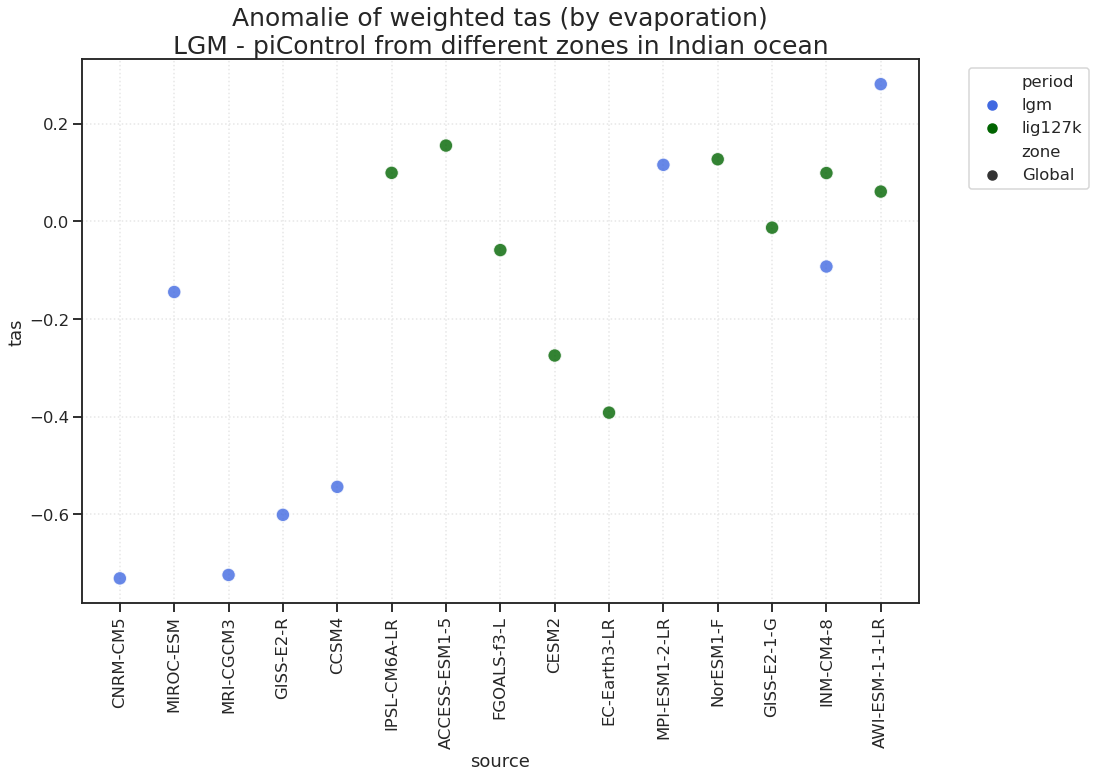

In [14]:
'''
On souhaite construire une figure observant la distribution des 
anomalies de la variable considérée dans le dataframe : df.
On les compares selon les modèles (x absciss), entre sous zones (couleurs) et entre périodes (style)

Les étapes :
    - Construction du style de la figure
    - Plot des nuages de points des données : df
    - Plot de l'intersection entre les points (si l'on souhaite)
    - Enregistrement de l'image
'''

var = 'tas'

sns.set_context("talk")
sns.set_style('ticks')
sns.set_context("talk") 
sns.set_style(
    'ticks', 
    {"grid.color":"0.9", 
     "grid.linestyle":":", 
     "axes.grid": True
    })
plt.figure(figsize = (15,10))

sns.scatterplot(
    data = df_all, 
    x = 'source', y = var, 
    style = 'zone', 
    hue = 'period', 
    s = 180, 
    alpha = 0.8, 
    palette = ['royalblue', 'darkgreen']
    )

'''
sns.lineplot(
    data = df, 
    x = 'source', y = var, 
    hue = 'zone', 
    style = 'period', 
    legend = False, 
    palette = 'tab10', 
    alpha = 0.3
)
'''

plt.legend(bbox_to_anchor=(1.05,1))
plt.xticks(rotation=90)
plt.title('Anomalie of weighted {} (by evaporation)\nLGM - piControl from different zones in Indian ocean'.format(var), fontsize = 25)
#plt.savefig('/home/bchaigneau/Stage_LSCE/plot/tas_weighted/anomalie_weighted_{}.jpeg'.format(var),dpi= 100, bbox_inches = 'tight')
plt.show()